# GSoC Coding challenge

### [Bilingual dictionary enrichment via graph completion](http://wiki.apertium.org/wiki/Ideas_for_Google_Summer_of_Code/Bilingual_dictionary_enrichment_via_graph_completion) 
### [Proposal](http://wiki.apertium.org/wiki/User:GD/proposal)

## DONE

1. 4 languages
2. Word object
3. Filter on sets
4. Graph
5. Translation with paths ( lemma, language, pos + target language -> all variant)

## TO DO

1. Code automatic extraction (from file names)
2. LR - RL differentiation
3. 

For toy-task it is possible to use Networkx (as it is available on Windows), but for general project it is more wisely to use powerful Graph-tool.

In [1]:
import networkx as nx

In [2]:
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore")

Let's take 4 strongly connected languages: Spanish, Catalan, French, English. I know French and English as foreign languages and Catalan an Spanish have their own pair so it will be easy to check results.

1. Spanish - Catalan
https://raw.githubusercontent.com/apertium/apertium-spa-cat/e871fb935e5f2d70572b8253431dde148f81f935/apertium-spa-cat.spa-cat.dix
2. French - Catalan
https://raw.githubusercontent.com/apertium/apertium-fra-cat/e388359e3c5e0753507098b1195079350523cae8/apertium-fra-cat.fra-cat.dix
3. English - Catalan
https://raw.githubusercontent.com/apertium/apertium-eng-cat/1d7c0dc28a57d5b57c5eb650f4e5b752b2140345/apertium-eng-cat.eng-cat.dix
4. English - Spanish
https://raw.githubusercontent.com/apertium/apertium-en-es/d0a72e428a23081aaf479d00f30d63053a149cce/apertium-en-es.en-es.dix
5. French - Spanish
https://raw.githubusercontent.com/apertium/apertium-fr-es/7901047303da621a1695b4a0df9a30e3c8418404/apertium-fr-es.fr-es.dix

In [4]:
LANG = nx.Graph()

In [5]:
elist = [('ES', 'CA'), ('FR', 'CA'), ('EN', 'CA'), ('FR', 'ES'), ('EN','ES')]

In [6]:
LANG.add_edges_from(elist)

In [7]:
LANG.nodes()

['ES', 'CA', 'FR', 'EN']

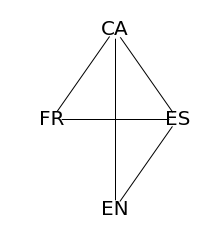

In [8]:
plt.subplot(121)
nx.draw_shell(LANG, with_labels = True, font_size = 20, node_color = 'white')
plt.show()

##  Data

In [4]:
import xml.etree.ElementTree as ET
import requests

Class Word for words that have lemma, lang and POS infromation. 

In [5]:
class Word:
    def __init__(self, lemma, lang, pos):
        self.lemma = lemma
        self.lang = lang
        self.pos = pos
    
    def __str__(self):
        return (str(self.lang)+'_'+str(self.lemma)+'_'+str(self.pos))
    
    __repr__ = __str__
    
    def __eq__(self, other):
        return self.lemma == other.lemma and self.lang == other.lang and self.pos == other.pos
    
    def __hash__(self):
        return hash(str(self))

List of files to load (4 languages)

In [6]:
list_of_files = [(('FR','CA'), 'https://raw.githubusercontent.com/apertium/apertium-fra-cat/e388359e3c5e0753507098b1195079350523cae8/apertium-fra-cat.fra-cat.dix'),
                (('EN','CA'), 'https://raw.githubusercontent.com/apertium/apertium-eng-cat/1d7c0dc28a57d5b57c5eb650f4e5b752b2140345/apertium-eng-cat.eng-cat.dix'),
                (('FR','ES'), 'https://raw.githubusercontent.com/apertium/apertium-fr-es/7901047303da621a1695b4a0df9a30e3c8418404/apertium-fr-es.fr-es.dix'),
                (('EN','ES'), 'https://raw.githubusercontent.com/apertium/apertium-en-es/d0a72e428a23081aaf479d00f30d63053a149cce/apertium-en-es.en-es.dix')
                ]

Set empty dictionary:

In [7]:
def set_dicts(list_of_files):
    total_dict = {}
    for i in list_of_files:
        if i[0][0] not in total_dict:
            total_dict[i[0][0]] = set()
        if i[0][1] not in total_dict:
            total_dict[i[0][1]] = set()
    return total_dict

In [8]:
total_dict = set_dicts(list_of_files)

In [9]:
total_dict

{'CA': set(), 'EN': set(), 'ES': set(), 'FR': set()}

### Parse dictionary

The simpliest version (take left and right word in bidix)

In [10]:
def parse_dictionary(tree, l1, l2):
    global total_dict, G
    for i in tree.find('section').findall('e'):
        try:
            w1 = i.find('p').find('l')
            w2 = i.find('p').find('r')
            if w1.text != None and w2.text != None:
                w1 = Word(w1.text, l1, w1.find('s').attrib['n'])
                if w1 not in total_dict[l1]:
                    total_dict[l1].add(w1)
                    G.add_node(w1)
                w2 = Word(w2.text, l2, w2.find('s').attrib['n'])
                if w2 not in total_dict[l2]:
                    total_dict[l2].add(w2)
                    G.add_node(w2)
                G.add_edge(w1,w2)
        except:
            pass

General function that loads data by the information in list_of_files

In [11]:
def load_dict (list_of_files):
    for pair in list_of_files:
        link = pair[1]
        l1 = pair[0][0]
        l2 = pair[0][1]
        response = requests.get(link)
        parse_dictionary(ET.fromstring(response.content), l1, l2)

Create an empty graph

In [12]:
G = nx.Graph()

Run loading function

In [13]:
load_dict (list_of_files)

In [14]:
print (len(G.nodes()), len(G.edges()))

162223 131437


Check equality of same elements

In [15]:
Word('lemma', 'FR','n') == Word('lemma','FR','n')

True

All objects in connectivity component (I don't know the exact term in English)

In [16]:
nx.descendants(G, Word('first', 'EN','adj'))

{ES_más_adj,
 ES_primo_adj,
 EN_foremost_adj,
 FR_premier_adj,
 CA_primer_adj,
 EN_prime_adj,
 ES_primero_adj,
 ES_primer_adj}

numpy to vectorize some operation to gain faster fuctions

In [17]:
import numpy as np

### Experiments and small pre-functions

In [24]:
def filter_lang(x, target_lang):
    if x.lang == target_lang:
        return x

In [25]:
filter_lang = np.vectorize(filter_lang)

In [26]:
filter_lang(list(nx.descendants(G, Word('first', 'EN','adj'))), 'CA')

array([None, None, None, None, None, None, CA_primer_adj, None],
      dtype=object)

In [27]:
def get_answers(word, target_lang):
    all_w = filter_lang(list(nx.descendants(G, Word('first', 'EN','adj'))), target_lang)
    all_w = filter(None, all_w.tolist())
    return (list(all_w))
    #print (all_w)

In [28]:
get_answers(Word('first', 'EN','adj'), 'CA')

[CA_primer_adj]

In [29]:
get_answers(Word('first', 'EN','adj'), 'CA')

[CA_primer_adj]

In [30]:
list(nx.all_simple_paths(G, Word('first', 'EN','adj'), Word('premier', 'FR','adj')))

[[EN_first_adj, CA_primer_adj, FR_premier_adj],
 [EN_first_adj, CA_primer_adj, EN_prime_adj, ES_primo_adj, FR_premier_adj],
 [EN_first_adj, ES_primero_adj, FR_premier_adj]]

### Actual Functions

SetWithFilter - set with methods of filtration of Word objects. Needs optimization as it uses cycles (instead of vectorized functions)

In [18]:
class SetWithFilter(set):
    def lemma(self, value):
        return set(i for i in self if i.lemma == value)
    def pos(self, value):
        return set(i for i in self if i.pos == value)
    def lang(self, value):
        return set(i for i in self if i.lang == value)
    def notlang(self, value):
        return set(i for i in self if i.lang != value)

Let's check lemma filter

In [19]:
q = SetWithFilter(G.nodes())

There are some homonyms

In [20]:
q.lemma('premier')

{ES_premier_n, EN_premier_n, FR_premier_adj, FR_premier_n}

#### translation_variants:

1. takes word object and target language code
2. checks whether there is such word
3. creates subgraph on nodes in connectivity component
4. gets descendants (reachable nodes in all languages) - connectivity component in subgraph
5. filters those in target language

6. prints paths (it should be returned as some more convenient type)
7. return translations

In [102]:
def translation_variants(word, lang):
    global G
    if word not in G.nodes():
        raise ValueError('No such word in a dictionary')
    new_nodes = SetWithFilter(nx.node_connected_component(G, word)).notlang(word.lang) | set([word])
    G_sub = G.subgraph(new_nodes)
    all_variants = SetWithFilter(nx.descendants(G_sub, word))
    all_variants = all_variants.lang(lang)
    print (all_variants)
    for translation in all_variants:
        print(list(nx.all_simple_paths(G_sub, word, translation)))
    return all_variants

In [57]:
translation_variants(Word('towards', 'EN','pr'), 'FR')

{FR_vers_pr, FR_envers_pr}
[[EN_towards_pr, CA_cap_pr, FR_vers_pr], [EN_towards_pr, CA_cap_pr, FR_envers_pr, ES_hacia_pr, FR_vers_pr], [EN_towards_pr, ES_hacia_pr, FR_vers_pr], [EN_towards_pr, ES_hacia_pr, FR_envers_pr, CA_cap_pr, FR_vers_pr]]
[[EN_towards_pr, CA_cap_pr, FR_vers_pr, ES_hacia_pr, FR_envers_pr], [EN_towards_pr, CA_cap_pr, FR_envers_pr], [EN_towards_pr, ES_hacia_pr, FR_vers_pr, CA_cap_pr, FR_envers_pr], [EN_towards_pr, ES_hacia_pr, FR_envers_pr]]


{FR_vers_pr, FR_envers_pr}

There is a probles with endless loop with some words (I suppose, prepositions mostly and some classes like this). There are lots of connections so there is a connectivity component with a lot of edges between words. As a consequence, there are a HUGE number of simple paths or it founds cycles and goes on them. Let's visualize:

In [93]:
def visualise_CC (word, lang):
    new_nodes = SetWithFilter(nx.node_connected_component(G, word)).notlang(word.lang) | set([word])
    G_sub = G.subgraph(new_nodes)
    nx.draw_shell(G_sub, with_labels = True, font_size = 10, node_color = 'white')
    plt.show()

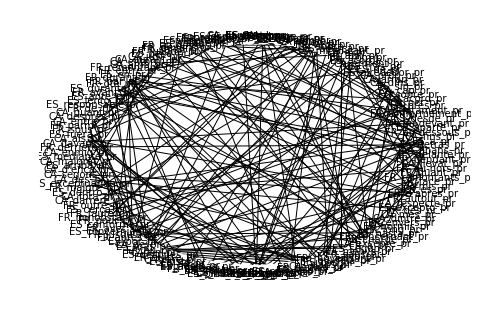

In [95]:
visualise_CC (Word('from', 'EN','pr'), 'FR')

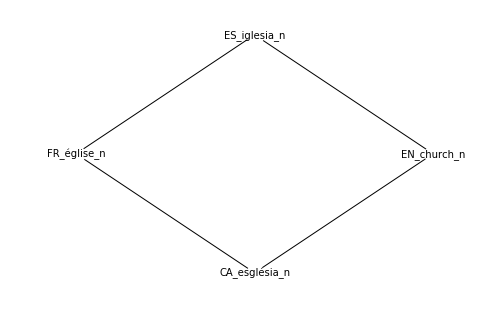

In [96]:
visualise_CC (Word('church', 'EN','n'), 'FR')

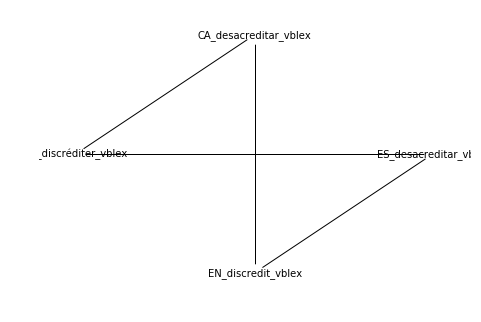

In [101]:
visualise_CC (Word('discredit', 'EN','vblex'), 'FR')

With a lot of nouns and verbs that haven't special meaning, there is also such problem so we need to reduce the number of paths via subgraphing for all variants. Like this: 

In [124]:
def translation_variants(word, lang):
    global G
    if word not in G.nodes():
        raise ValueError('No such word in a dictionary')
    new_nodes = SetWithFilter(nx.node_connected_component(G, word)).notlang(word.lang) | set([word])
    G_sub = G.subgraph(new_nodes)
    all_variants = SetWithFilter(nx.descendants(G_sub, word))
    all_variants = all_variants.lang(lang)
    print ('Connected in connectivity component: ', len(all_variants), end='\n\n')
    for translation in all_variants:
        new_nodes = SetWithFilter(G_sub.nodes()).notlang(translation.lang) | set([word, translation])
        G_sub2 = G_sub.subgraph(new_nodes)
        paths = list(nx.all_simple_paths(G_sub2, word, translation))
        if paths:
            print(translation, '\t', paths)
        #nx.draw_shell(G_sub2, with_labels = True, font_size = 10, node_color = 'white')
        #plt.show()
    #return all_variants

In [132]:
translation_variants(Word('from', 'EN','pr'), 'FR')

Connected in connectivity component:  53

FR_le_pr 	 [[EN_from_pr, ES_a_pr, FR_le_pr]]
FR_depuis_pr 	 [[EN_from_pr, ES_desde_pr, FR_depuis_pr]]
FR_au-dessous_pr 	 [[EN_from_pr, CA_a_pr, FR_au-dessous_pr]]
FR_dans_pr 	 [[EN_from_pr, CA_a_pr, FR_dans_pr]]
FR_au-dessus_pr 	 [[EN_from_pr, CA_a_pr, FR_au-dessus_pr]]
FR_au-devant_pr 	 [[EN_from_pr, CA_a_pr, FR_au-devant_pr]]
FR_malgré_pr 	 [[EN_from_pr, ES_a_pr, FR_malgré_pr]]
FR_de_pr 	 [[EN_from_pr, ES_de_pr, FR_de_pr], [EN_from_pr, CA_de_pr, FR_de_pr]]
FR_en_pr 	 [[EN_from_pr, ES_a_pr, FR_en_pr], [EN_from_pr, CA_de_pr, FR_en_pr], [EN_from_pr, CA_a_pr, FR_en_pr]]
FR_conformément_pr 	 [[EN_from_pr, ES_de_pr, FR_conformément_pr]]
FR_dès_pr 	 [[EN_from_pr, ES_desde_pr, FR_dès_pr]]
FR_outre_pr 	 [[EN_from_pr, CA_a_pr, FR_outre_pr]]
FR_près_pr 	 [[EN_from_pr, CA_a_pr, FR_près_pr]]
FR_faute_pr 	 [[EN_from_pr, ES_a_pr, FR_faute_pr]]
FR_autour_pr 	 [[EN_from_pr, CA_a_pr, FR_autour_pr]]
FR_à_pr 	 [[EN_from_pr, ES_a_pr, FR_à_pr], [EN_from_pr, CA_a_p

In [126]:
translation_variants(Word('run', 'EN','vblex'), 'FR')

Connected in connectivity component:  293

FR_courir_vblex 	 [[EN_run_vblex, ES_correr_vblex, FR_courir_vblex], [EN_run_vblex, CA_córrer_vblex, FR_courir_vblex]]
FR_écraser_vblex 	 [[EN_run_vblex, CA_atropellar_vblex, FR_écraser_vblex], [EN_run_vblex, ES_atropellar_vblex, FR_écraser_vblex]]
FR_risquer_vblex 	 [[EN_run_vblex, ES_correr_vblex, FR_risquer_vblex]]
FR_ramasser_vblex 	 [[EN_run_vblex, ES_estar_vblex, FR_ramasser_vblex]]
FR_être_vblex 	 [[EN_run_vblex, ES_estar_vblex, FR_être_vblex]]
FR_approuver_vblex 	 [[EN_run_vblex, ES_estar_vblex, FR_approuver_vblex]]
FR_faire_vblex 	 [[EN_run_vblex, ES_estar_vblex, FR_faire_vblex]]
FR_échouer_vblex 	 [[EN_run_vblex, CA_encallar_vblex, FR_échouer_vblex]]
FR_avoir_vblex 	 [[EN_run_vblex, ES_estar_vblex, FR_avoir_vblex]]
FR_branler_vblex 	 [[EN_run_vblex, ES_estar_vblex, FR_branler_vblex]]
FR_agir_vblex 	 [[EN_run_vblex, ES_estar_vblex, FR_agir_vblex]]
FR_fonctionner_vblex 	 [[EN_run_vblex, CA_funcionar_vblex, FR_fonctionner_vblex], [EN_ru

Pretty long-time function (if compare with lighter situations as below)

In [127]:
translation_variants(Word('fight', 'EN','vblex'), 'FR')

Connected in connectivity component:  4

FR_lutter_vblex 	 [[EN_fight_vblex, CA_lluitar_vblex, FR_lutter_vblex], [EN_fight_vblex, ES_luchar_vblex, FR_lutter_vblex]]
FR_défendre_vblex 	 [[EN_fight_vblex, CA_defensar_vblex, FR_défendre_vblex]]
FR_bagarrer_vblex 	 [[EN_fight_vblex, CA_lluitar_vblex, FR_bagarrer_vblex], [EN_fight_vblex, ES_luchar_vblex, FR_bagarrer_vblex]]


In [129]:
translation_variants(Word('conquer', 'EN','vblex'), 'FR')

Connected in connectivity component:  1

FR_conquérir_vblex 	 [[EN_conquer_vblex, CA_conquistar_vblex, FR_conquérir_vblex], [EN_conquer_vblex, CA_conquerir_vblex, FR_conquérir_vblex], [EN_conquer_vblex, ES_conquistar_vblex, FR_conquérir_vblex]]


So it helps to narrow down possibilities as we cut off some irrelevant variants (they are connected only because they exist in the same connectivity component)

*** I do understand that this is one-time solution as we do a hard procedure of subgraphing a lot of times.
So I think better one is to transform edges to target language to directed ones in one-word subgraph in order to avoid these cycles***